<a href="https://colab.research.google.com/github/idptools/idpcolab/blob/main/STARLING/STARLING_ensemble_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STARLING colab (STARLING 2.0)
#### Last updated 2025-10-26
Welcome to the STARLING colab notebook. This notebook enables you to setup STARLING using a Google Colab instance and generate ensemble of disordered proteins directly from sequence.

## About
This notebook allows you to predict an ensemble of conformations from sequence, and then that ensembles is downloaded as a PDB ensemble. Alternatively, you can download a compressed trajectory representation as an XTC file if download_xtc box is checked.

This notebook is designed to enable easy construction of IDP ensembles, but lacks many of the advanced features provided by STARLING.

## STARLING version
This notebook uses the current main version of [STARLING](https://github.com/idptools/starling), which is STARLING version 2.0 at the time of writing. The version reported in the STARLING preprint is a different model and different archiecture to the final version. Specifically, we previously used a [UNET](https://en.wikipedia.org/wiki/U-Net) as part of the diffusion model, whereas we now use a [Vision Transformer (ViT)](https://en.wikipedia.org/wiki/Vision_transformer). We have resubmitted an updated version of the STARLING manuscript after an initial round of reviews, which details this updated version (TLDR, harder better faster stronger). We are unable to update the preprint online as per the publisher's rules; however, if you would like to read the updated version please contact [Alex](https://www.holehouselab.com/team) and he will happily send you a PDF.

## Reference

**Accurate predictions of conformational ensembles of disordered proteins with STARLING.**
Novak, B., Lotthammer, J. M., Emenecker, R. J. & Holehouse, A. S. bioRxiv 2025.02. 14.638373 (2025). [doi:10.1101/2025.02.14.638373](https://doi.org/10.1101/2025.02.14.638373)
  


### Changelog


In [18]:
#@title [**Notebook setup**] Setup the notebook (installs deps, checks GPU) { display-mode: "form" }
#@markdown This first cell needs to be run once, and will set up the STARLING
#@markdown environment and run download the model weights. This will take ~30
#@markdown seconds the first time but only needs to be done once and will run
#@markdown in a few seconds if re-run again. Hit the ▶️ to run!


from IPython.display import display, HTML
import os
display(HTML("""
<p><b>Welcome to STARLING Colab</b> 👋<br>
This cell must be run once to set up the STARLING environment.<br>
</p>
"""))

# You can tweak verbosity by toggling CAPTURE_OUTPUT below.
CAPTURE_OUTPUT = True  # set to False if you want to see full logs

import os, sys, subprocess, textwrap
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets

def sh(cmd, check=True):
    """Run a shell command in a login bash so $PATH updates stick."""
    return subprocess.run(["bash", "-lc", cmd], check=check)

def start():
    if CAPTURE_OUTPUT:
        print('Setting up STARLING environment...')
        from contextlib import redirect_stdout, redirect_stderr
        from io import StringIO
        _buf_out, _buf_err = StringIO(), StringIO()
        with redirect_stdout(_buf_out), redirect_stderr(_buf_err):
            _do_setup()
        # Show only a concise success / GPU status message
        _final_message()
    else:
        _do_setup()
        _final_message()

def _do_setup():
    print("Setting up environment…")
    # Install uv (adds to ~/.cargo/bin)
    sh("curl -LsSf https://astral.sh/uv/install.sh | sh")
    # Add uv to PATH for the current Python process
    os.environ["PATH"] += f":{os.environ['HOME']}/.cargo/bin"
    # Use uv to install your package (quietly)
    sh("uv pip install -q idptools-starling")
    sh("uv pip install -q ipywidgets")
    sh("uv pip install -q afrc")

    # Optional: pre-import torch to check GPU
    import torch  # noqa: F401

    # Import starling so generate() is ready for users
    global generate
    from starling import generate  # noqa: F401
    globals()["generate"] = generate

def _final_message():
    import torch
    if not torch.cuda.is_available():
        display(HTML(
            "<div style='color:#b00020; font-weight:bold; font-size:14px;'>"
            "🚨 GPU not detected!<br>"
            "Go to <b>Runtime → Change runtime type → Hardware accelerator → GPU</b> and select <b>GPU</b>."
            "</div>"
        ))
    else:
        name = torch.cuda.get_device_name(0)
        display(HTML(
            f"<div style='color:#0b8043; font-weight:bold; font-size:14px;'>"
            f"✅ Setup complete. GPU active: {name}</div>"
        ))
        from starling import generate
        print('Downloading STARLING network weights (this only needs to happen once!)...')
        tmp = generate('EPEPEPEPEPE', conformations=1, verbose=False)
        print('Weights downloaded!')

def _do_download(e, download_xtc, download_starling):
    pdb_path = 'ensemble.pdb'
    xtc_path = 'ensemble.xtc'
    starling_path = 'ensemble.starling'
    zip_filename = "ensemble_files.zip"

    # first clean up everything
    if os.path.exists(pdb_path):
        os.remove(pdb_path)

    if os.path.exists(xtc_path):
        os.remove(xtc_path)

    if os.path.exists(zip_filename):
        os.remove(zip_filename)

    if os.path.exists(starling_path):
        os.remove(starling_path)


    # next save things
    if download_starling:
        e.save('ensemble')
    if download_xtc:
        e.save_trajectory('ensemble')
    else:
        e.save_trajectory('ensemble', pdb_trajectory=True)


    # option 1: XTC +/- STARLING
    # if we're going to download a PDB and an XTC file
    if download_xtc:
        with zipfile.ZipFile(zip_filename, 'w') as zipf:
          zipf.write('ensemble.pdb')
          zipf.write('ensemble.xtc')
          if download_starling:
              zipf.write('ensemble.starling')

        if _wait_for_file(zip_filename, timeout=60):
            print(f"✅ Saved: {zip_filename}")
            if auto_download:
                files.download(zip_filename)
        else:
            print(f"❌ Failed to save {zip_filename} within timeout.")

    # option 2: PDB ensemble + STARLING
    # if we're going to download a PDB (+/- STARLING)
    elif download_starling:

        with zipfile.ZipFile(zip_filename, 'w') as zipf:
            zipf.write('ensemble.pdb')
            zipf.write('ensemble.starling')

        if _wait_for_file(zip_filename, timeout=60):
            print(f"✅ Saved: {zip_filename}")
            if auto_download:
                files.download(zip_filename)
        else:
            print(f"❌ Failed to save {zip_filename} within timeout.")

    # option 3: PDB ensemble only
    else:
        if _wait_for_file(pdb_path, timeout=60):
            print(f"✅ Saved: {pdb_path}")
            if auto_download:
                files.download(pdb_path)
            else:
                print("❌ Failed to save ensemble.pdb within timeout.")


start()  # runs when this cell is executed

Setting up STARLING environment...


Using DDIM sampler


Progress through sequences:   0%|          | 0/1 [00:00<?, ?it/s]

DDIM steps (batch 1 of 1):   0%|          | 0/31 [00:00<?, ?it/s]

Weights downloaded!


In [27]:
#@title [**Ensemble Generation**] Predict ensembles for further analysis { display-mode: "form" }
#@markdown This cell does the actual ensemble prediction. It can be re-run to generate new ensembles, but all subsequence cells will act on the most recent time this cell was run

import os, time, shutil
from google.colab import files
import zipfile


# --- Plain form fields (no ipywidgets) ---
#@markdown <br>**Input options**
sequence = "MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGSIAAATGFVKKDQLGKNEEGAPQEGILEDMPVDPDNEAYEMPSEEGYQDYEPEA" #@param {type:"string"}
conformations = 510 #@param {type:"slider", min:10, max:1000, step:50}
ionic_strength = 150 #@param {type:"slider", min:20, max:300, step:1}

#@markdown <br>**Output options**
auto_download = True #@param {type:"boolean"}
download_xtc = True #@param {type:"boolean"}

def _wait_for_file(path, timeout=60):
    t0 = time.time()
    while not os.path.exists(path):
        if time.time() - t0 > timeout:
            return False
        time.sleep(0.1)
    return True

# --- Main logic ---
if not sequence.strip():
    print("❌ Please enter a protein sequence.")
elif scaling_map_min >= scaling_map_max:
    print("❌ Please ensure scaling_map_min is smaller than scaling_map_max.")
else:
    if len(sequence) > 382:
      print("❌ Cannot cope with sequences > 382 residues.")

    elif len(sequence) < 3:
      print("❌ Cannot cope with sequences < 3 residues.")
    else:
      display(HTML(
      f"""
      <div style='color:#000000; font-size:15px; line-height:1.5;'>
        <div><h3>Performing ensemble generation with STARLING</h3></div>
        <div><b>Number of conformations to be generated</b>: {conformations}</div>
        <div><b>Ionic Strength</b>: {ionic_strength} mM</div>
        <div style='margin-top:12px;'>
            <span style='font-weight:bold;'>Sequence:</span><br>
            <pre style='background-color:#f5f5f5; padding:10px; border-radius:5px; font-family:Courier, monospace; font-size:13px; white-space:pre-wrap; word-break:break-word;'>
{sequence}
            </pre>
        </div>
        <div><h3>Output below:</h3></div>
    </div>
      """
      ))
      # Assume `generate` exists
      e = generate(
          sequence,
          conformations=conformations,
          return_single_ensemble=True,
          pdb_trajectory=True,
          ionic_strength=ionic_strength
      )

      if auto_download:
          _do_download(e, download_xtc, False)

      display(HTML(
            f"<div style='color:#0b8043; font-weight:bold; font-size:14px;'>"
            f"✅ Ensemble generation complete. Generated an ensemble with  {len(e)} conformations</div>"
        ))




Using DDIM sampler


Progress through sequences:   0%|          | 0/1 [00:00<?, ?it/s]

DDIM steps (batch 1 of 6):   0%|          | 0/31 [00:00<?, ?it/s]

DDIM steps (batch 2 of 6):   0%|          | 0/31 [00:00<?, ?it/s]

DDIM steps (batch 3 of 6):   0%|          | 0/31 [00:00<?, ?it/s]

DDIM steps (batch 4 of 6):   0%|          | 0/31 [00:00<?, ?it/s]

DDIM steps (batch 5 of 6):   0%|          | 0/31 [00:00<?, ?it/s]

DDIM steps (batch 6 of 6):   0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

✅ Saved: ensemble_files.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Ensemble analysis
The remaining cells in this notebook can be run in any order, and represent different types of analysis that can be done on the

/tmp/ipython-input-2922126771.py:36: RuntimeWarning: invalid value encountered in divide
  sm = e.distance_maps(return_mean=True)/AnalyticalFRC(e.sequence).get_distance_map(symmetric_map=True)


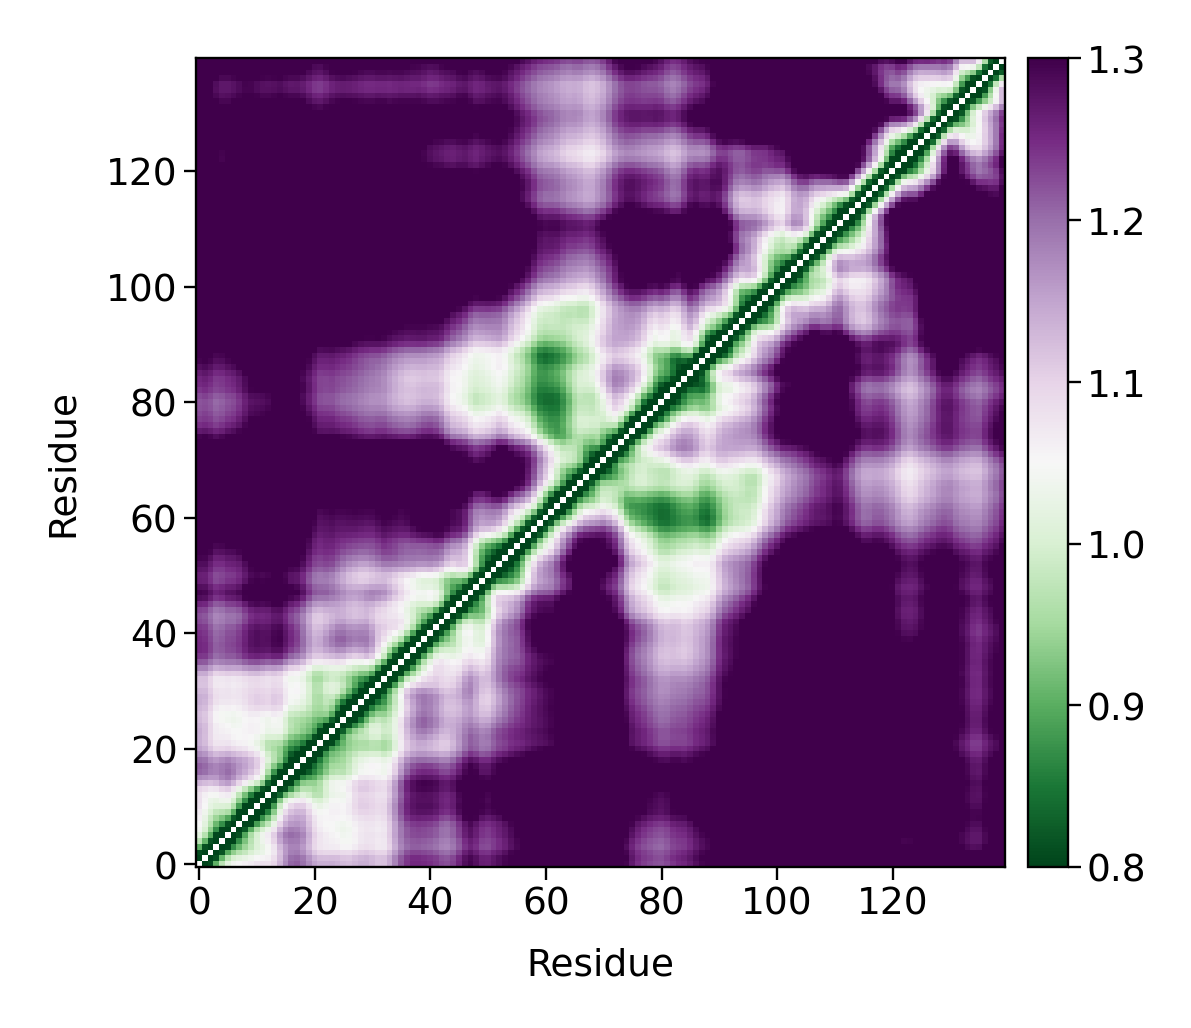

In [16]:
#@title [**Ensemble Analysis**] Vizualize scaling map { display-mode: "form" }
#@markdown **What is a scaling map?**<br> Scaling maps report on the normalized average distance between all pairs of residues in an ensemble. Normalization here is done using the Analytical Random Coil (AFRC) model, which basically is a toy model that reports on the expected distance between pairs of residues in an IDP if sequence chemistry had no impact on the conformational behavior and the IDP behaved akin to a Gaussian chain.
#@markdown For more information on the AFRC, see [Alston & Ginell et al. 2023](https://pubs.acs.org/doi/10.1021/acs.jpcb.3c01619)<br>

#@markdown <br>**Scaling map options**
scaling_map_min = 0.8 #@param {type:"slider", min:0.5, max:1.5, step:0.05}
scaling_map_max = 1.3 #@param {type:"slider", min:0.5, max:1.5, step:0.05}
colormap = 'PRGn_r' # @param ['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', 'Blues_r', 'BrBG_r', 'BuGn_r', 'BuPu_r', 'CMRmap_r', 'GnBu_r', 'Greens_r', 'Greys_r', 'OrRd_r', 'Oranges_r', 'PRGn_r', 'PiYG_r', 'PuBu_r', 'PuBuGn_r', 'PuOr_r', 'PuRd_r', 'Purples_r', 'RdBu_r', 'RdGy_r', 'RdPu_r', 'RdYlBu_r', 'RdYlGn_r', 'Reds_r', 'Spectral_r', 'Wistia_r', 'YlGn_r', 'YlGnBu_r', 'YlOrBr_r', 'YlOrRd_r', 'afmhot_r', 'autumn_r', 'binary_r', 'bone_r', 'brg_r', 'bwr_r', 'cool_r', 'coolwarm_r', 'copper_r', 'cubehelix_r', 'flag_r', 'gist_earth_r', 'gist_gray_r', 'gist_heat_r', 'gist_ncar_r', 'gist_rainbow_r', 'gist_stern_r', 'gist_yarg_r', 'gnuplot_r', 'gnuplot2_r', 'gray_r', 'hot_r', 'hsv_r', 'jet_r', 'nipy_spectral_r', 'ocean_r', 'pink_r', 'prism_r', 'rainbow_r', 'seismic_r', 'spring_r', 'summer_r', 'terrain_r', 'winter_r', 'Accent_r', 'Dark2_r', 'Paired_r', 'Pastel1_r', 'Pastel2_r', 'Set1_r', 'Set2_r', 'Set3_r', 'tab10_r', 'tab20_r', 'tab20b_r', 'tab20c_r']


from afrc import AnalyticalFRC
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1

mpl.rcParams['xtick.major.size'] = 2  # Major tick length for x-axis
mpl.rcParams['xtick.minor.size'] = 0.5   # Minor tick length for x-axis
mpl.rcParams['ytick.major.size'] = 2  # Major tick length for y-axis
mpl.rcParams['ytick.minor.size'] = 0.5   # Minor tick length for y-axis

mpl.rcParams['xtick.major.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.major.width'] = 0.375  # Major tick width for y-axis
mpl.rcParams['xtick.minor.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.minor.width'] = 0.375  # Major tick width for y-axis

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.375

sm = e.distance_maps(return_mean=True)/AnalyticalFRC(e.sequence).get_distance_map(symmetric_map=True)

fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=450)

# Main image
im = ax.imshow(sm, cmap=colormap, vmin=scaling_map_min, vmax=scaling_map_max, origin='lower')
plt.xlabel('Residue', fontsize=6)
plt.ylabel('Residue', fontsize=6)

# Match colorbar height to the image
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Colorbar with matched height
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=6)  # set font size of colorbar ticks

# Axis tick font sizes
ax.tick_params(labelsize=6)

plt.show()



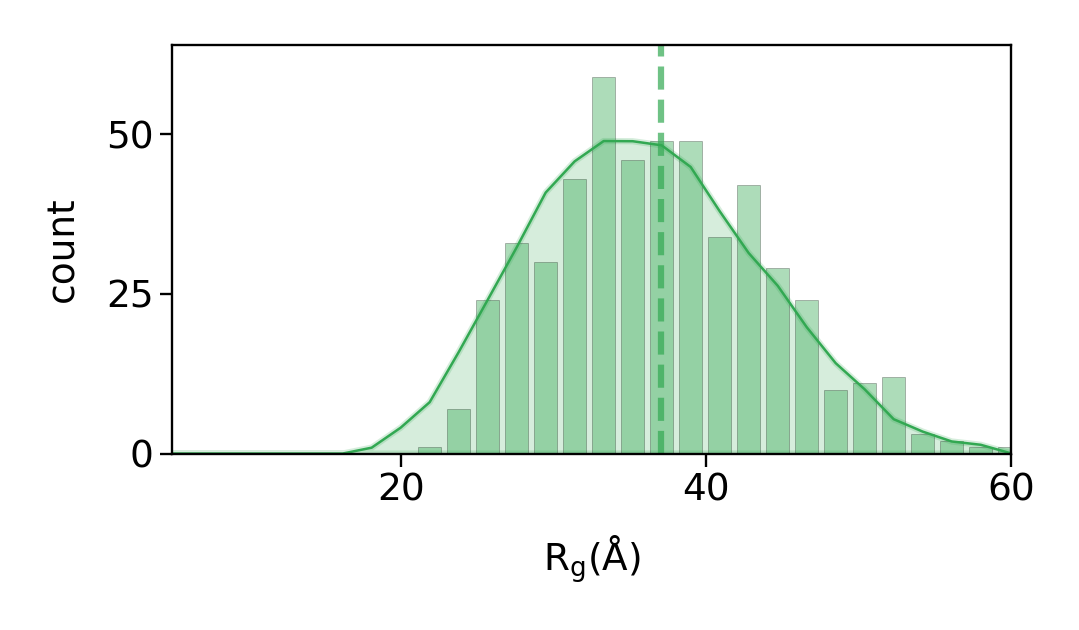

In [70]:
#@title [**Ensemble Analysis**] Radius of gyration distribution

#@markdown **Plotting options**
color = '#32a852' # @param {type:"string"}
nbins = 20 # @param {type:"number"}
xmin = 5 # @param {type:"number"}
xmax = 60 # @param {type:"number"}

#@markdown <br>**Advanced options**
smoothing_window_size = 12 # @param {type:"number"}
smoothing_polynomial_order = 2 # @param {type:"number"}

#@markdown <br>**Experimental data (optional)**
experimental_value = -1 # @param {type:"number"}

import numpy as np
from scipy.signal import savgol_filter


if nbins < 2:
  raise Exception("nbins must be >2")

def get_histogram_vals(vals, bw=5, bmin=0, bmax=120, wl=5, polyorder=2):

    bins = np.arange(bmin,bmax,bw)
    [a,b]= np.histogram(vals,bins=bins)

    smoothed = savgol_filter(a,wl,polyorder)

    smoothed[smoothed<0]=0
    return b[1:]-bw*0.5, a, smoothed

def plot_histo(e,
               color,
               nbins=20,
               bmin=0,
               bmax=120,
               wl=5,
               polyorder=2,
               xmin=5,
               xmax=60,
               exp_value=-1):
    figure(None, (2.5, 1.5), dpi=450)
    ax = plt.gca()
    rg_vals = e.radius_of_gyration()
    bw = (max(rg_vals) - min(rg_vals))/nbins

    X = get_histogram_vals(rg_vals, bw=bw, bmin=bmin, bmax=max(bmax,xmax), wl=wl, polyorder=polyorder)

    plt.plot(X[0],X[2], color=color, lw=0.4)
    plt.fill_between(X[0], 0, X[2], alpha=0.2, color=color, label='STARLING')
    plt.bar(X[0],X[1], width=bw*0.8, color=color,alpha=0.4, edgecolor='k',lw=0.1)
    plt.ylim([0, max(X[1])+int(max(X[1])*0.1)])
    plt.xlim([xmin, xmax])
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.ylabel('count', fontsize=6)
    plt.xlabel(r'$\rm R_g $' + '(Å)', fontsize=6)


    ax.axvline(np.mean(rg_vals), color=color,lw=1, alpha=0.7,ls='--')

    if exp_value != -1:
        ax.axvline(exp_value, color='k',lw=1, alpha=0.7,ls='-', label='experiment')
        plt.legend(frameon=False, fontsize=4)



    plt.tight_layout()


plot_histo(e,
           color,
           nbins=nbins,
           wl=smoothing_window_size,
           xmin=xmin,
           xmax=xmax,
           exp_value=experimental_value)

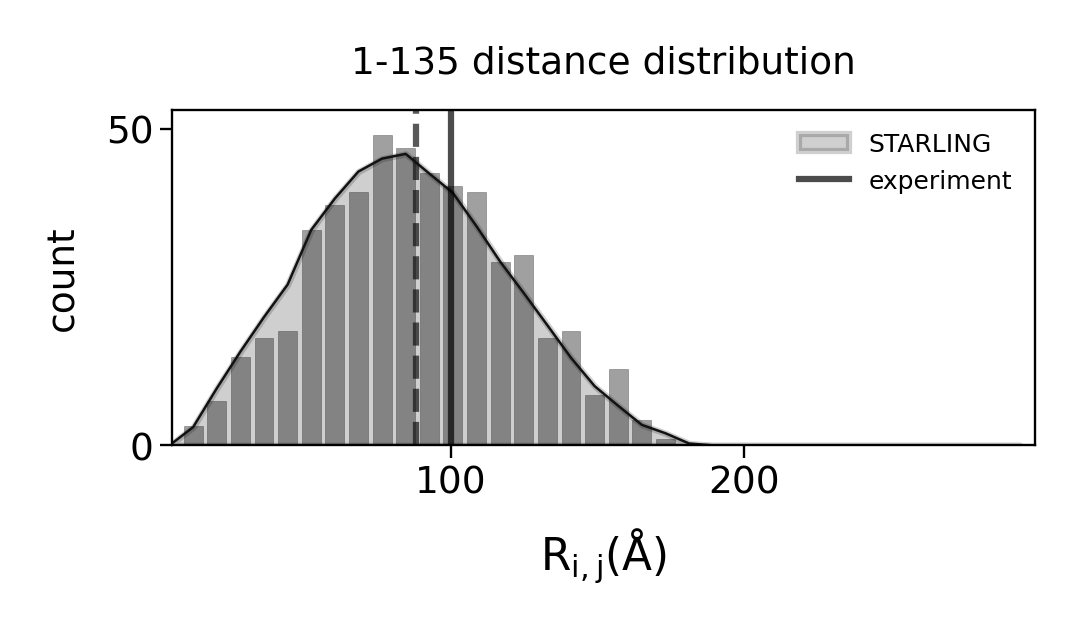

In [72]:
#@title [**Ensemble Analysis**] Inter-residue distance distribution

#@markdown **Selection options**
residue_1 = 1 # @param {type:"integer"}
residue_2 = 135 # @param {type:"integer"}

if residue_1 < 1 or residue_2 < 1:
  raise Exception('Residues must be 1 or greater')
if residue_1 > len(e.sequence) or residue_2 > len(e.sequence):
  raise Exception('Residues cannot be longer than sequence ({len(e.sequence)})')


#@markdown **Plotting options**
color = '#121212' # @param {type:"string"}
nbins = 20 # @param {type:"number"}
xmin = 5 # @param {type:"number"}
xmax = 299 # @param {type:"number"}

#@markdown <br>**Advanced options**
smoothing_window_size = 12 # @param {type:"number"}
smoothing_polynomial_order = 2 # @param {type:"number"}

#@markdown <br>**Experimental data (optional)**
experimental_value = 100 # @param {type:"number"}

import numpy as np
from scipy.signal import savgol_filter


if nbins < 2:
  raise Exception("nbins must be >2")

def get_histogram_vals(vals, bw=5, bmin=0, bmax=120, wl=5, polyorder=2):

    bins = np.arange(bmin,bmax,bw)
    [a,b]= np.histogram(vals,bins=bins)

    smoothed = savgol_filter(a,wl,polyorder)

    smoothed[smoothed<0]=0
    return b[1:]-bw*0.5, a, smoothed

def plot_histo(e,
               r1,
               r2,
               color,
               nbins=20,
               bmin=0,
               bmax=120,
               wl=5,
               polyorder=2,
               xmin=5,
               xmax=60,
               exp_value=-1):
    figure(None, (2.5, 1.5), dpi=450)
    ax = plt.gca()
    r_vals = e.rij(r1,r2)
    bw = (max(r_vals) - min(r_vals))/nbins

    X = get_histogram_vals(r_vals, bw=bw, bmin=bmin, bmax=max(bmax,xmax), wl=wl, polyorder=polyorder)

    plt.plot(X[0],X[2], color=color, lw=0.4)
    plt.fill_between(X[0], 0, X[2], alpha=0.2, color=color, label='STARLING')
    plt.bar(X[0],X[1], width=bw*0.8, color=color,alpha=0.4, edgecolor='k',lw=0.1)
    plt.ylim([0, max(X[1])+int(max(X[1])*0.1)])
    plt.xlim([xmin, xmax])
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.ylabel('count', fontsize=6)
    plt.xlabel(r'$\rm R_{i,j} $' + '(Å)', fontsize=7)
    plt.title(f"{r1}-{r2} distance distribution", fontsize=6)


    ax.axvline(np.mean(r_vals), color=color,lw=1, alpha=0.7,ls='--')

    if exp_value != -1:
        ax.axvline(exp_value, color='k',lw=1, alpha=0.7,ls='-', label='experiment')
        plt.legend(frameon=False, fontsize=4)



    plt.tight_layout()


plot_histo(e,
           r1=residue_1,
           r2=residue_2,
           color=color,
           nbins=nbins,
           wl=smoothing_window_size,
           xmin=xmin,
           xmax=xmax,
           exp_value=experimental_value)

In [ ]:
#@title [Step 4] Download ensemble { display-mode: "form" }
#@markdown <br>**Output options**

download_xtc = False #@param {type:"boolean"}
download_starling = False #@param {type:"boolean"}
